In [1]:
#pip install geopandas shapely

In [2]:
import pandas as pd
import geopandas as gpd  
from shapely import wkt  

# 读取CSV文件  
nyc_data = pd.read_csv('nycd.csv')  # 先读取为 DataFrame，而不是 GeoDataFrame  

# 将 the_geom 列转换为几何对象  
nyc_data['geometry'] = nyc_data['the_geom'].apply(wkt.loads)  # 将 WKT 转换为几何对象  

# 创建 GeoDataFrame  
nyc_data = gpd.GeoDataFrame(nyc_data, geometry='geometry')  

# 检查数据  
print(nyc_data.head())  

# 计算多边形的中心点  
nyc_data['centroid'] = nyc_data.geometry.centroid  # 计算每个多边形的中心点  

# 提取中心点的坐标  
nyc_data['centroid_x'] = nyc_data['centroid'].x  
nyc_data['centroid_y'] = nyc_data['centroid'].y  

# 显示结果  
print(nyc_data[['BoroCD', 'centroid_x', 'centroid_y']].head())  

# Optional: 保存结果到CSV文件  
nyc_data[['BoroCD', 'centroid_x', 'centroid_y']].to_csv('nyc_centroids.csv', index=False)

                                            the_geom  BoroCD     Shape_Leng  \
0  MULTIPOLYGON (((-73.95829216807752 40.67983113...     308   38232.886649   
1  MULTIPOLYGON (((-73.89138023380261 40.86170058...     205   29443.048056   
2  MULTIPOLYGON (((-73.97299433938896 40.60881414...     311   51534.144746   
3  MULTIPOLYGON (((-73.85722330984474 40.65027867...     410  105822.376914   
4  MULTIPOLYGON (((-73.94923327082499 40.79687199...     164   32721.097627   

     Shape_Area                                           geometry  
0  4.560379e+07  MULTIPOLYGON (((-73.95829 40.67983, -73.95596 ...  
1  3.831698e+07  MULTIPOLYGON (((-73.89138 40.8617, -73.89142 4...  
2  1.032083e+08  MULTIPOLYGON (((-73.97299 40.60881, -73.97296 ...  
3  1.720774e+08  MULTIPOLYGON (((-73.85722 40.65028, -73.85902 ...  
4  3.831238e+07  MULTIPOLYGON (((-73.94923 40.79687, -73.94942 ...  
   BoroCD  centroid_x  centroid_y
0     308  -73.946599   40.674355
1     205  -73.909580   40.852746
2     311

In [3]:
import pandas as pd  

# 读取纽约城市数据  
nyc_data = pd.read_csv('nyc_centroids.csv')  # 先读取为 DataFrame  

# 打印列名和前几行，确认数据结构  
print(nyc_data.columns)  
print(nyc_data.head())

Index(['BoroCD', 'centroid_x', 'centroid_y'], dtype='object')
   BoroCD  centroid_x  centroid_y
0     308  -73.946599   40.674355
1     205  -73.909580   40.852746
2     311  -73.993638   40.607213
3     410  -73.832735   40.669367
4     164  -73.965559   40.782473


In [4]:
import pandas as pd  
import geopandas as gpd  
from shapely.geometry import Point  

# 读取纽约城市数据  
nyc_data = pd.read_csv('nyc_centroids.csv')  

# 读取空气质量数据  
air_quality_data = pd.read_csv('Air_Quality_20241205.csv')  
print(air_quality_data.head())  # 查看数据以确认列名  

# Geo Join ID 与 BoroCD 直接关联，并创建一个新的列  
air_quality_data['BoroCD'] = air_quality_data['Geo Join ID']  

# 将空气质量数据与中心点数据合并  
combined_data = air_quality_data.merge(nyc_data[['BoroCD', 'centroid_x', 'centroid_y']], on='BoroCD', how='left')  

# 创建 GeoDataFrame  
combined_data['geometry'] = combined_data.apply(lambda row: Point(row['centroid_x'], row['centroid_y']), axis=1)  
air_quality_gdf = gpd.GeoDataFrame(combined_data, geometry='geometry')  

# 设置坐标系（CRS），例如为WGS 84  
air_quality_gdf.crs = "EPSG:4326"  

# 显示合并后的数据  
print(air_quality_gdf.head())  

# Optional: 保存结果到CSV文件  
air_quality_gdf.to_csv('air_quality_with_centroids.csv', index=False)

   Unique ID  Indicator ID                                   Name  \
0     179772           640  Boiler Emissions- Total SO2 Emissions   
1     179785           640  Boiler Emissions- Total SO2 Emissions   
2     178540           365                Fine particles (PM 2.5)   
3     178561           365                Fine particles (PM 2.5)   
4     823217           365                Fine particles (PM 2.5)   

          Measure Measure Info Geo Type Name  Geo Join ID  \
0  Number per km2       number         UHF42        409.0   
1  Number per km2       number         UHF42        209.0   
2            Mean       mcg/m3         UHF42        209.0   
3            Mean       mcg/m3         UHF42        409.0   
4            Mean       mcg/m3         UHF42        409.0   

            Geo Place Name          Time Period  Start_Date  Data Value  \
0         Southeast Queens                 2015  01/01/2015         0.3   
1  Bensonhurst - Bay Ridge                 2015  01/01/2015         

In [5]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


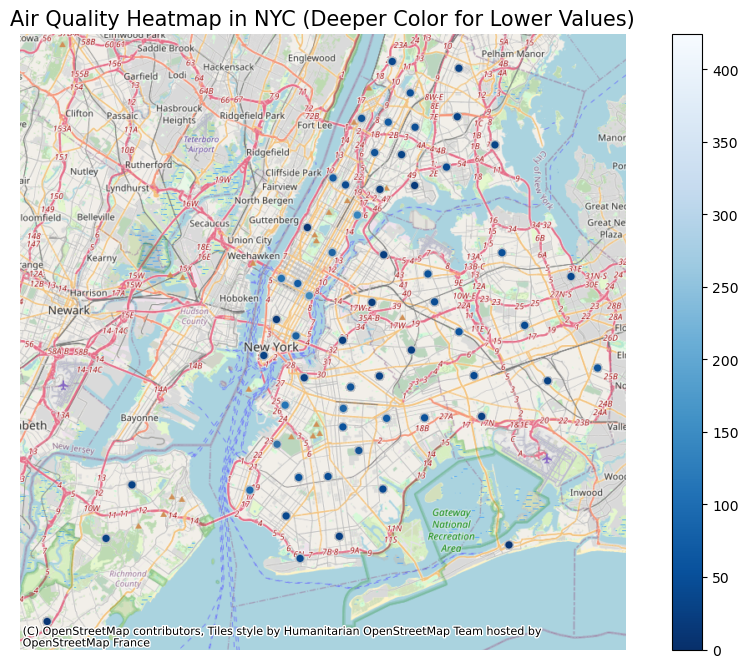

In [6]:
import pandas as pd  
import geopandas as gpd  
import matplotlib.pyplot as plt  
from shapely.geometry import Point  
import contextily as ctx  # 用于添加底图  

# 读取合并后的空气质量数据  
air_quality_gdf = pd.read_csv('air_quality_with_centroids.csv')  

# 将 DataFrame 转换为 GeoDataFrame  
air_quality_gdf['geometry'] = air_quality_gdf.apply(lambda row: Point(row['centroid_x'], row['centroid_y']), axis=1)  
air_quality_gdf = gpd.GeoDataFrame(air_quality_gdf, geometry='geometry')  

# 设置坐标系（CRS）为 WGS 84  
air_quality_gdf.crs = "EPSG:4326"  

# 确保处理缺失值，去掉含有NaN的行（如果有的话）  
air_quality_gdf = air_quality_gdf.dropna(subset=['Data Value'])  

# 将 CRS 转换为 Web Mercator 投影  
air_quality_gdf = air_quality_gdf.to_crs(epsg=3857)  

# 创建热力图  
fig, ax = plt.subplots(figsize=(12, 8))  

# 反向颜色映射，从小值到大值的映射  
air_quality_gdf.plot(column='Data Value',  # 使用 'Data Value' 列  
                     cmap='Blues_r',  # 选择反向的颜色映射  
                     alpha=0.6,  # 设置透明度  
                     linewidth=0.8,  # 边界宽度  
                     ax=ax,  # 所在的 ax 对象  
                     edgecolor='0.8',  # 边界颜色  
                     legend=True)  # 显示图例  

# 添加底图  
ctx.add_basemap(ax, crs=air_quality_gdf.crs.to_string())  # 添加底图  

# 去掉背景和坐标轴  
ax.set_facecolor('none')  # 设置背景透明  
ax.set_xticks([])  # 关闭 x 轴刻度  
ax.set_yticks([])  # 关闭 y 轴刻度  
ax.set_axis_off()  # 关闭坐标轴显示  

# 配置图形标题  
ax.set_title('Air Quality Heatmap in NYC (Deeper Color for Lower Values)', fontsize=15)  

# 展示热力图  
plt.show()  

# Optional: 保存热力图为图像文件  
fig.savefig('air_quality_heatmap_with_basemap.png', dpi=300, bbox_inches='tight')

In [7]:
import pandas as pd  

# 加载数据  
df = pd.read_csv('air_quality_with_centroids.csv')  

# 查看前几行数据  
print(df.head())

   Unique ID  Indicator ID                                   Name  \
0     179772           640  Boiler Emissions- Total SO2 Emissions   
1     179785           640  Boiler Emissions- Total SO2 Emissions   
2     178540           365                Fine particles (PM 2.5)   
3     178561           365                Fine particles (PM 2.5)   
4     823217           365                Fine particles (PM 2.5)   

          Measure Measure Info Geo Type Name  Geo Join ID  \
0  Number per km2       number         UHF42        409.0   
1  Number per km2       number         UHF42        209.0   
2            Mean       mcg/m3         UHF42        209.0   
3            Mean       mcg/m3         UHF42        409.0   
4            Mean       mcg/m3         UHF42        409.0   

            Geo Place Name          Time Period  Start_Date  Data Value  \
0         Southeast Queens                 2015  01/01/2015         0.3   
1  Bensonhurst - Bay Ridge                 2015  01/01/2015         

In [8]:
# 查看数据框的基本信息  
print(df.info())  

# 查看数据的统计描述  
print(df.describe())  

# 检查唯一的污染物和测量方式  
unique_indicators = df['Name'].unique()  
unique_measures = df['Measure'].unique()  
print(f"Unique Indicators: {unique_indicators}")  
print(f"Unique Measures: {unique_measures}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18025 entries, 0 to 18024
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unique ID       18025 non-null  int64  
 1   Indicator ID    18025 non-null  int64  
 2   Name            18025 non-null  object 
 3   Measure         18025 non-null  object 
 4   Measure Info    18025 non-null  object 
 5   Geo Type Name   18025 non-null  object 
 6   Geo Join ID     18016 non-null  float64
 7   Geo Place Name  18016 non-null  object 
 8   Time Period     18025 non-null  object 
 9   Start_Date      18025 non-null  object 
 10  Data Value      18025 non-null  float64
 11  Message         0 non-null      float64
 12  BoroCD          18016 non-null  float64
 13  centroid_x      16133 non-null  float64
 14  centroid_y      16133 non-null  float64
 15  geometry        18025 non-null  object 
dtypes: float64(6), int64(2), object(8)
memory usage: 2.2+ MB
None
           Uni

In [9]:
# 提取"Annual Average 2021"的所有数据  
annual_average_2021_df = df[df['Time Period'] == 'Annual Average 2021']

In [10]:
# 定义需要分析的污染物  
pollutants = ['Fine particles (PM 2.5)', 'Nitrogen dioxide (NO2)', 'Boiler Emissions- Total SO2 Emissions']  

# 描述性统计分析结果  
for pollutant in pollutants:  
    pollutant_data = annual_average_2021_df[annual_average_2021_df['Name'] == pollutant]  
    print(f'Descriptive Analysis for {pollutant}:')  
    print(pollutant_data['Data Value'].describe())  
    print('\n')  

Descriptive Analysis for Fine particles (PM 2.5):
count    141.000000
mean       6.760993
std        0.563759
min        5.900000
25%        6.400000
50%        6.600000
75%        7.000000
max        8.900000
Name: Data Value, dtype: float64


Descriptive Analysis for Nitrogen dioxide (NO2):
count    141.000000
mean      17.004255
std        2.591190
min       11.100000
25%       15.300000
50%       16.700000
75%       18.600000
max       25.200000
Name: Data Value, dtype: float64


Descriptive Analysis for Boiler Emissions- Total SO2 Emissions:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Data Value, dtype: float64




SO2在Annual Average 2021中缺失全部数据

In [12]:
pollutants = ['Fine particles (PM 2.5)', 'Nitrogen dioxide (NO2)']  

Fine particles (PM 2.5) Data Length: 141
Nitrogen dioxide (NO2) Data Length: 141


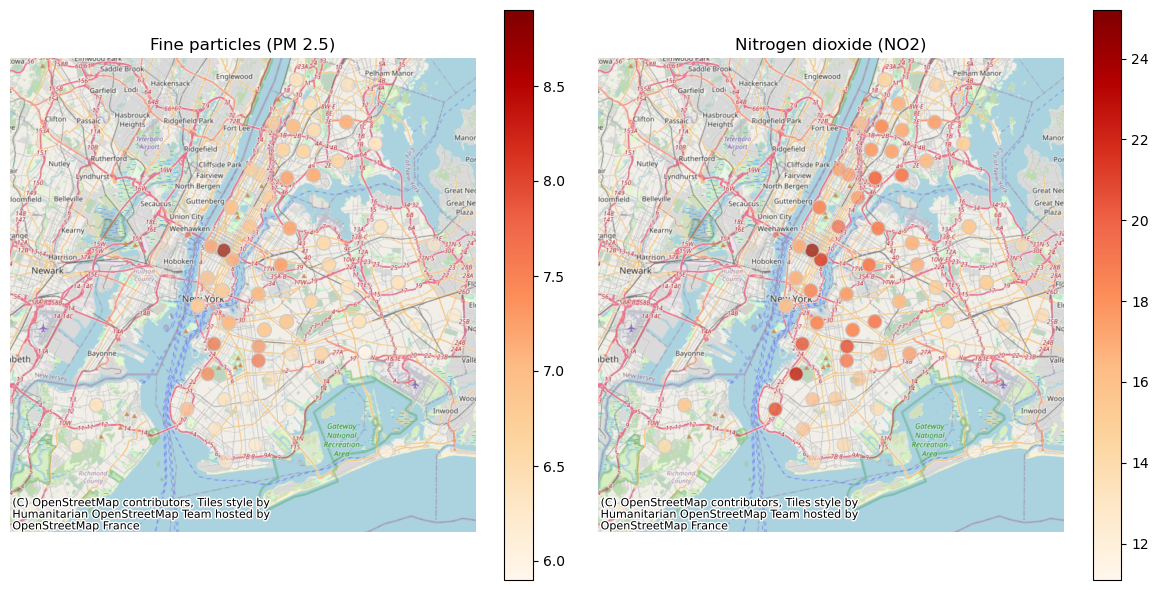

In [13]:
#热力图  

# 将 DataFrame 转换为 GeoDataFrame  
annual_average_2021_df.loc[:, 'geometry'] = annual_average_2021_df.apply(lambda row: Point(row['centroid_x'], row['centroid_y']), axis=1)  
gdf = gpd.GeoDataFrame(annual_average_2021_df, geometry='geometry')  

# 设置坐标系为 WGS 84  
gdf.crs = "EPSG:4326"  

# 转换 CRS 为 Web Mercator  
gdf = gdf.to_crs(epsg=3857)  

# 针对不同污染物进行绘制热力图  
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 修改为2个子图  

for ax, pollutant in zip(axes, pollutants):  
    pollutant_data = gdf[gdf['Name'] == pollutant]  
    
    print(f"{pollutant} Data Length: {len(pollutant_data)}")  # 检查数据长度  
    if not pollutant_data.empty:  
        pollutant_data.plot(column='Data Value',  
                            markersize=100,
                            cmap='OrRd',  
                            alpha=0.6,  
                            linewidth=0.8,  
                            ax=ax,  
                            edgecolor='0.8',  
                            legend=True)  

        # 添加底图  
        ctx.add_basemap(ax, crs=gdf.crs.to_string())  

        # 设置标题  
        ax.set_title(pollutant)  
        ax.set_axis_off()  
    else:  
        print(f"No data available for {pollutant}.")  

# 调整布局  
plt.tight_layout()  
plt.show()  

In [14]:
print(annual_average_2021_df.head())  
print(annual_average_2021_df.columns)

    Unique ID  Indicator ID                     Name Measure Measure Info  \
31     741006           375   Nitrogen dioxide (NO2)    Mean          ppb   
39     742215           365  Fine particles (PM 2.5)    Mean       mcg/m3   
40     742257           365  Fine particles (PM 2.5)    Mean       mcg/m3   
57     740946           375   Nitrogen dioxide (NO2)    Mean          ppb   
70     742269           365  Fine particles (PM 2.5)    Mean       mcg/m3   

   Geo Type Name  Geo Join ID           Geo Place Name          Time Period  \
31         UHF42        410.0                Rockaways  Annual Average 2021   
39         UHF42        211.0  Williamsburg - Bushwick  Annual Average 2021   
40         UHF42        404.0    Bayside - Little Neck  Annual Average 2021   
57         UHF42        211.0  Williamsburg - Bushwick  Annual Average 2021   
70         UHF42        408.0                  Jamaica  Annual Average 2021   

    Start_Date  Data Value  Message  BoroCD  centroid_x  centr

            Geo Place Name  Data Value_PM2.5  Data Value_NO2
0  Williamsburg - Bushwick               7.2            19.0
1  Williamsburg - Bushwick               7.2            19.0
2    Bayside - Little Neck               6.3            13.9
3                  Jamaica               6.4            15.3
4                  Jamaica               6.4            15.3


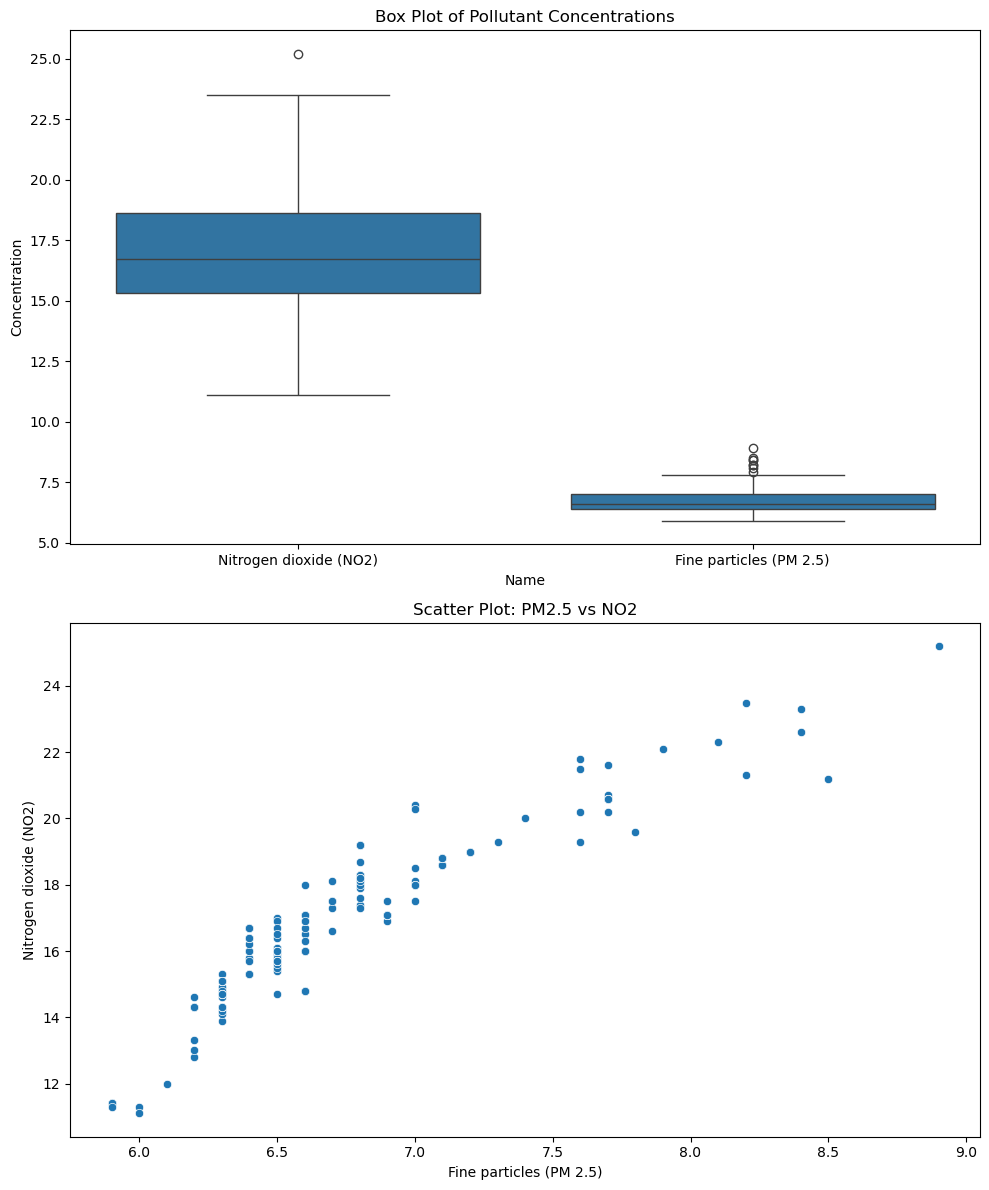

In [15]:
import pandas as pd  
import geopandas as gpd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from shapely.geometry import Point  

# 加载数据  
df = pd.read_csv('air_quality_with_centroids.csv')  

# 提取"Annual Average 2021"的所有数据  
annual_average_2021_df = df[df['Time Period'] == 'Annual Average 2021'].copy()  

# 定义需要分析的污染物  
pollutants = ['Fine particles (PM 2.5)', 'Nitrogen dioxide (NO2)']  

# 创建新的 DataFrame 来存储两个污染物的数据  
scatter_data = annual_average_2021_df[annual_average_2021_df['Name'].isin(pollutants)]  

# 提取相关的污染物数据  
pm25_data = scatter_data[scatter_data['Name'] == 'Fine particles (PM 2.5)']  
no2_data = scatter_data[scatter_data['Name'] == 'Nitrogen dioxide (NO2)']  

# 创建一个新的 DataFrame，使得两种污染物的数据按位置合并  
merged_data = pd.merge(pm25_data[['Geo Place Name', 'Data Value']],   
                        no2_data[['Geo Place Name', 'Data Value']],   
                        on='Geo Place Name',   
                        suffixes=('_PM2.5', '_NO2'))  

# 检查合并后的 DataFrame  
print(merged_data.head())  

# 可视化  
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  

# 1. 箱型图  
sns.boxplot(data=scatter_data,  
             x='Name', y='Data Value', ax=axes[0])  
axes[0].set_title('Box Plot of Pollutant Concentrations')  
axes[0].set_ylabel('Concentration')  

# 2. 散点图  
sns.scatterplot(data=merged_data,  
                x='Data Value_PM2.5',   
                y='Data Value_NO2',   
                ax=axes[1])  
axes[1].set_title('Scatter Plot: PM2.5 vs NO2')  
axes[1].set_xlabel('Fine particles (PM 2.5)')  
axes[1].set_ylabel('Nitrogen dioxide (NO2)')  

plt.tight_layout()  
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


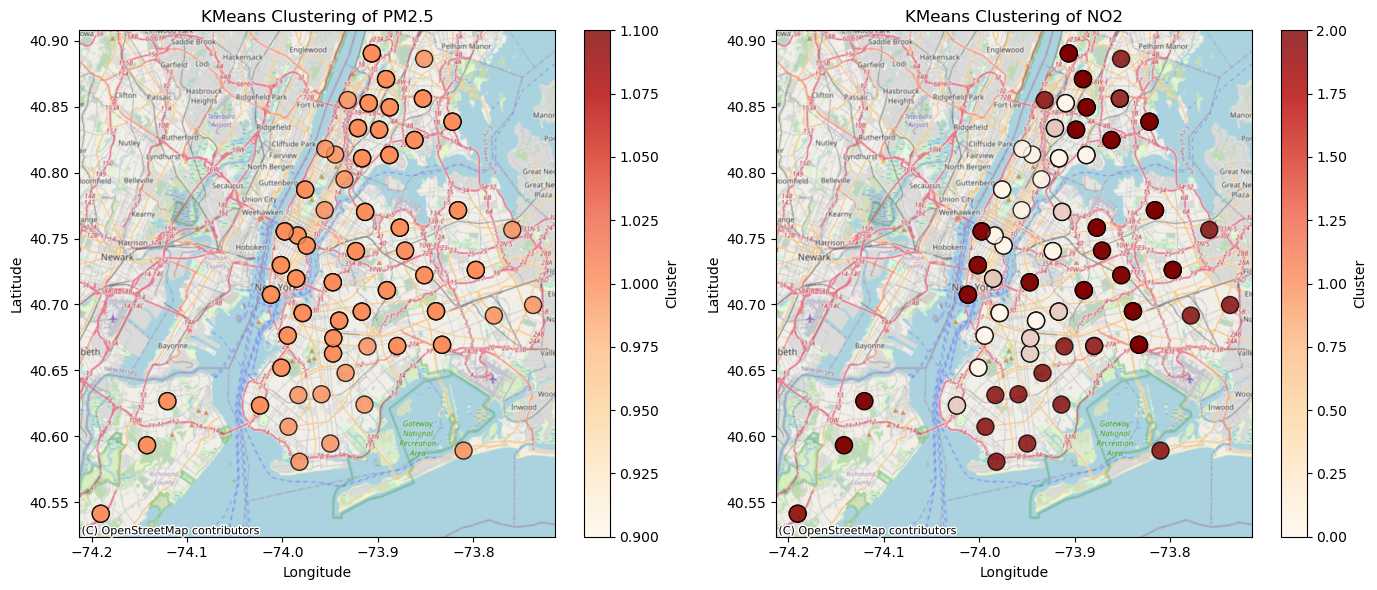

In [16]:
#聚类

import os  
import pandas as pd  
import geopandas as gpd  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans  
from sklearn.preprocessing import StandardScaler  
import contextily as ctx  

# 设置环境变量以避免 KMeans 内存泄漏警告  
os.environ["OMP_NUM_THREADS"] = "1"  

# 为 PM2.5 和 NO2 创建一个新的 DataFrame  
clustering_data = annual_average_2021_df[annual_average_2021_df['Name'].isin(['Fine particles (PM 2.5)', 'Nitrogen dioxide (NO2)'])].copy()  

# 将每种污染物的浓度数据分开  
pm25_data = clustering_data[clustering_data['Name'] == 'Fine particles (PM 2.5)'][['centroid_x', 'centroid_y', 'Data Value', 'Name']]  
no2_data = clustering_data[clustering_data['Name'] == 'Nitrogen dioxide (NO2)'][['centroid_x', 'centroid_y', 'Data Value', 'Name']]  

# 检查并丢弃缺失值  
pm25_data = pm25_data.dropna()  
no2_data = no2_data.dropna()  

# 合并 PM2.5 和 NO2 数据  
combined_data = pd.concat([pm25_data, no2_data], ignore_index=True)  

# 标准化数据  
scaler = StandardScaler()  
scaler.fit(combined_data[['Data Value']])  
scaled_values = scaler.transform(combined_data[['Data Value']])  

# 创建 GeoDataFrame  
combined_scaled = pd.DataFrame(scaled_values, columns=['Data Value'])  
combined_scaled[['centroid_x', 'centroid_y', 'Name']] = combined_data[['centroid_x', 'centroid_y', 'Name']]  
geometry = gpd.points_from_xy(combined_scaled['centroid_x'], combined_scaled['centroid_y'])  
gdf = gpd.GeoDataFrame(combined_scaled, geometry=geometry)  
gdf.crs = 'EPSG:4326'  

# KMeans 聚类  
kmeans = KMeans(n_clusters=3)  
gdf['Cluster'] = kmeans.fit_predict(gdf[['Data Value', 'centroid_x', 'centroid_y']])  

# 可视化  
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

# PM2.5聚类结果  
ax1 = axes[0]  
ax1.set_title('KMeans Clustering of PM2.5')  
pm25_scaled = gdf[gdf['Name'] == 'Fine particles (PM 2.5)']  
pm25_scaled.plot(kind='scatter', x='centroid_x', y='centroid_y',   
                 c='Cluster', cmap='OrRd',  # 使用更明显的色谱  
                 ax=ax1, alpha=0.8,  # 增加透明度  
                 edgecolor='black',  # 散点边框颜色  
                 s=150)  # 增加散点大小  

# 添加底图  
ctx.add_basemap(ax1, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)  

ax1.set_xlabel('Longitude')  
ax1.set_ylabel('Latitude')  

# NO2聚类结果  
ax2 = axes[1]  
ax2.set_title('KMeans Clustering of NO2')  
no2_scaled = gdf[gdf['Name'] == 'Nitrogen dioxide (NO2)']  
no2_scaled.plot(kind='scatter', x='centroid_x', y='centroid_y',   
                 c='Cluster', cmap='OrRd',  # 使用更明显的色谱  
                 ax=ax2, alpha=0.8,  # 增加透明度  
                 edgecolor='black',  # 散点边框颜色  
                 s=150)  # 增加散点大小  

# 添加底图  
ctx.add_basemap(ax2, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)  

ax2.set_xlabel('Longitude')  
ax2.set_ylabel('Latitude')  

plt.tight_layout()  
plt.show()